In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Modelling import MiningInstance, MiningLocation, EtheriumParams, estimate_profit
import seaborn as sns

## Data loading and processing

In [2]:
df_etherium_prices = pd.read_csv('data/ETH-USD.csv', sep=';')
df_etherium_prices = df_etherium_prices[['Date', 'Adj Close']]
df_etherium_prices.rename(columns={'Adj Close': 'Price'}, inplace=True)
mask = ('2017-01' <= df_etherium_prices['Date']) & (df_etherium_prices['Date'] <= '2018-12')
df_etherium_prices = df_etherium_prices.loc[mask, :].reset_index(drop=True)

In [3]:
hashrates = pd.read_csv('data/network_hashrate.csv', sep=';')

df = df_etherium_prices.merge(hashrates, on='Date')

df.rename(columns={'Date': 'Month'}, inplace=True)

Several mining instances are creared using class `MiningInstance`.

In [4]:
core_i7 = MiningInstance(name='Intel Core i7 3630QM', hashrate=0.04, power=45, cost=100)
radeon_vega = MiningInstance(name='Radeon RX Vega', hashrate=37.5, power=200, cost=650)
# amd_rx_580 = MiningInstance(name='Radeon RX 580', hashrate=25, power=175, cost=290, release_month='2017-04')
nvidia_gtx_1060 = MiningInstance(name='Nvidia GTX 1060', hashrate=22, power=100, cost=280)
# nvidia_gtx_1080_ti = MiningInstance(name='Nvidia GTX 1080 Ti', hashrate=37.5, power=200)
radeon_R9_295_X2 = MiningInstance(name='Radeon R9 295 X2', hashrate=46, power=500, cost=1100)
asic = MiningInstance(name='ASIC', hashrate=180, power=800, cost=800, release_month='2018-08')
fgpa = MiningInstance(name='FPGA', hashrate=1900, power=225, cost=4000, release_month='2018-08')

`EthereumParams` and `MiningLocation` classes initialization.

In [5]:
etherium_params = EtheriumParams(block_reward=3, block_time=15, network_hashrate=166*10**6, etherium_price=110)
mining_location = MiningLocation(0.1, 'Somethere on the Earth')

In [6]:
mining_instance_list = [radeon_vega, nvidia_gtx_1060, radeon_R9_295_X2, asic, fgpa]  # core_i7
mining_instance_dict = {mining_instance.name: mining_instance for mining_instance in mining_instance_list}

In [7]:
mining_instances_results = {}

for mining_instance_name, mining_instance in mining_instance_dict.items():
    profit_results_list = []

    for n_row in range(df.shape[0]):
        month = df.loc[n_row, 'Month']
        etherium_price = df.loc[n_row, 'Price']
        network_hashrate = df.loc[n_row, 'network_hashrate']

        etherium_params.etherium_price = etherium_price
        etherium_params.network_hashrate = network_hashrate * 10 ** 6

        value_from_mining, cost_for_electricity, profit = estimate_profit(mining_instance, mining_location, etherium_params)
        profit_result = {
            'Month': month,
            'value_from_mining': value_from_mining,
            'cost_for_electricity': cost_for_electricity,
            'profit_per_second': profit,
            'profit_per_month': profit * 60 * 60 * 24 * 30,
        }
        profit_results_list.append(profit_result)

    df_mining_instance = pd.DataFrame(profit_results_list)
    mining_instances_results[mining_instance_name] = df_mining_instance

### Drawing a plot for comparing different instances.

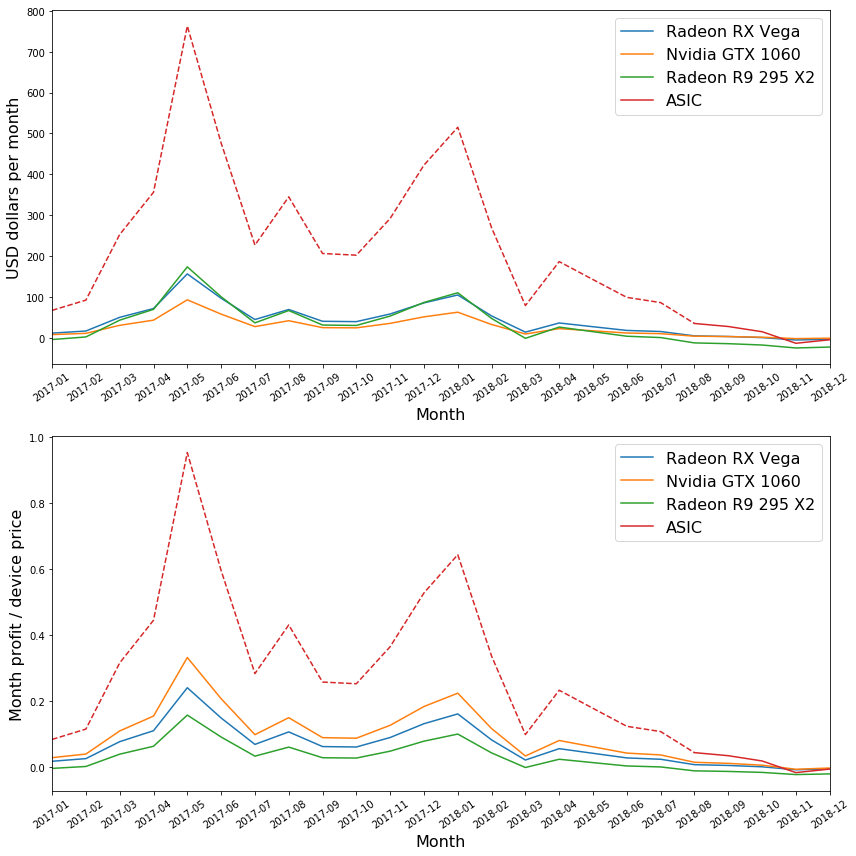

In [8]:
plt.close()
fig, ax = plt.subplots(2, 1, figsize=(12, 12))#, sharex=True)

for mining_instances_name, mining_instances_result in mining_instances_results.items():
    if mining_instances_name in ['FPGA']:
        continue

    months = mining_instances_result['Month'].values
    profit_per_month = mining_instances_result['profit_per_month']
    cost = mining_instance_dict[mining_instances_name].cost
    release_month = mining_instance_dict[mining_instances_name].release_month

    if release_month is None:
        ax[0].plot(months, profit_per_month, label=mining_instances_name)
        ax[1].plot(months, profit_per_month/cost, label=mining_instances_name)
    else:
        mask_before = months <= release_month
        mask_after = months >= release_month
        ax[0].plot(months[mask_before], profit_per_month[mask_before].values, linestyle='--', alpha=1)
        ax[1].plot(months[mask_before], profit_per_month[mask_before].values/cost, linestyle='--', alpha=1)
        color_0 = ax[0].lines[-1]._color
        color_1 = ax[1].lines[-1]._color
        ax[0].plot(months[mask_after], profit_per_month[mask_after], label=mining_instances_name, color=color_0)
        ax[1].plot(months[mask_after], profit_per_month[mask_after]/cost, label=mining_instances_name, color=color_1)

for axis_num in [0, 1]:
    ax[axis_num].tick_params(axis='x', rotation=35)
#     ax[axis_num].tick_params(axis='x', 
    ax[axis_num].set_xlabel('Month', fontsize=16)
#     xlabels_new = list(ax[axis_num].get_xticklabels())
#     print(xlabels_new)
#     xlabels_new = [xlabel._text for xlabel in xlabels_new]
#     ax[axis_num].set_xticklabels(xlabels_new, fontsize=14)
# #     ax[axis_num].set_yticklabels(list(ax[axis_num].get_yticklabels()), fontsize=14)
# #     ax[axis_num].set_yticklabels(, fontsize=14)
    

ax[0].set_xlim(0, len(months) - 1)
ax[1].set_xlim(0, len(months) - 1)
    
ax[0].set_ylabel('USD dollars per month', fontsize=16)
ax[1].set_ylabel('Month profit / device price', fontsize=16)
# ax[0].set_title('MMining profit')

ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
# plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('pic/profit.png', )

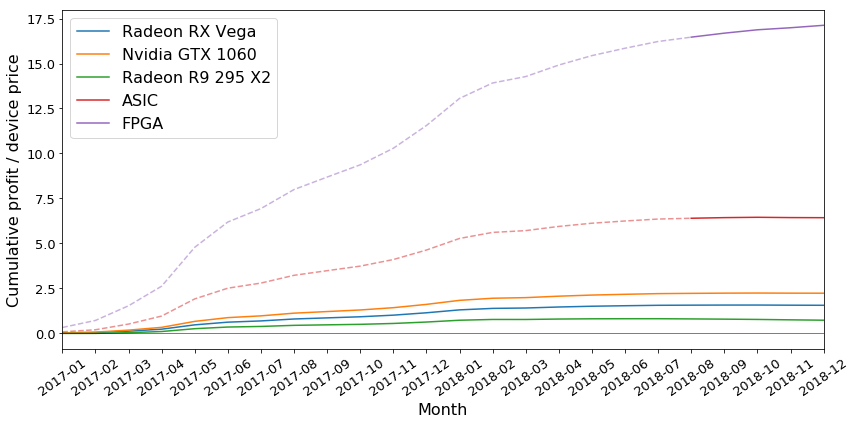

In [9]:
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))#, sharex=True)

for mining_instances_name, mining_instances_result in mining_instances_results.items():
#     if mining_instances_name in ['FPGA', 'ASIC']:
#         continue
    
    months = mining_instances_result['Month'].values
    profit_per_month = mining_instances_result['profit_per_month']
    cost = mining_instance_dict[mining_instances_name].cost
    release_month = mining_instance_dict[mining_instances_name].release_month
    cumulative_sum = np.cumsum(profit_per_month) / cost

    if release_month is None:
        ax.plot(months, cumulative_sum, label=mining_instances_name)
    else:
        mask_before = months <= release_month
        mask_after = months >= release_month
        ax.plot(months[mask_before], cumulative_sum[mask_before].values, linestyle='--', alpha=0.5)
        color_0 = ax.lines[-1]._color
        ax.plot(months[mask_after], cumulative_sum[mask_after], label=mining_instances_name, color=color_0)

ax.set_xlim(0, len(months) - 1)
ax.tick_params(axis='x', rotation=35)#, size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_xlabel('Month', fontsize=16)
plt.axhline(0, color='black', alpha=1, lw=0.5)
ax.set_ylabel('Cumulative profit / device price', fontsize=16)

ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig('pic/profit__a.png')

### Payoff plot.

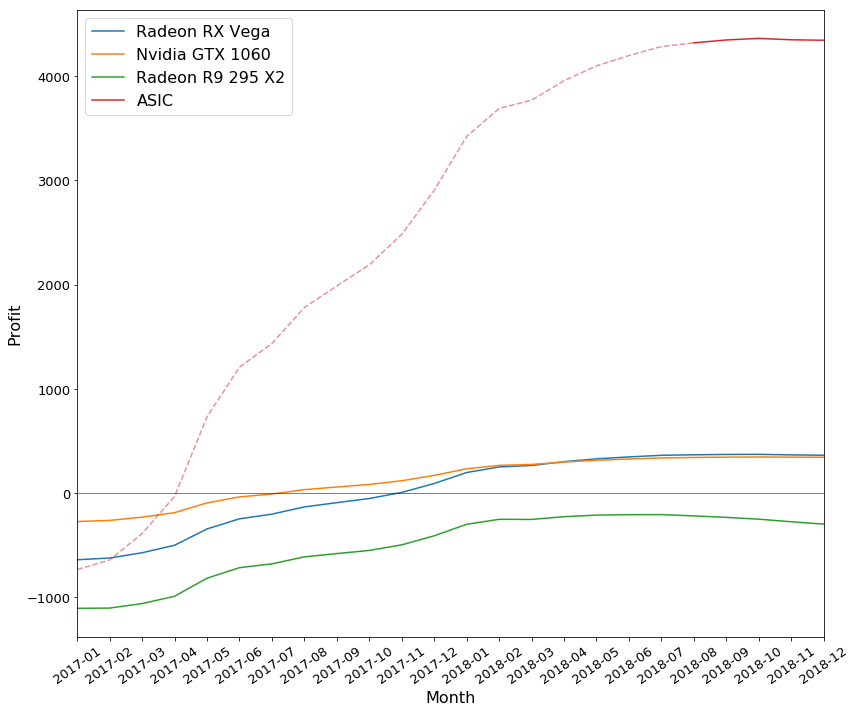

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))#, sharex=True)

for mining_instances_name, mining_instances_result in mining_instances_results.items():
    if mining_instances_name in ['FPGA']:# 'ASIC']:
        continue
    
    months = mining_instances_result['Month'].values
    profit_per_month = mining_instances_result['profit_per_month']
    cost = mining_instance_dict[mining_instances_name].cost
    release_month = mining_instance_dict[mining_instances_name].release_month
    cumulative_sum = -cost + np.cumsum(profit_per_month)

    if release_month is None:
        ax.plot(months, cumulative_sum, label=mining_instances_name)
    else:
        mask_before = months <= release_month
        mask_after = months >= release_month
        ax.plot(months[mask_before], cumulative_sum[mask_before].values, linestyle='--', alpha=0.5)
        color_0 = ax.lines[-1]._color
        ax.plot(months[mask_after], cumulative_sum[mask_after], label=mining_instances_name, color=color_0)

ax.set_xlim(0, len(months) - 1)
ax.tick_params(axis='x', rotation=35)#, size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_xlabel('Month', fontsize=16)
plt.axhline(0, color='black', alpha=1, lw=0.5)
ax.set_ylabel('Profit', fontsize=16)

ax.legend(fontsize=16)
# plt.title('')
plt.tight_layout()
plt.savefig('pic/profit__p.png')

### Investigating location dependence

In [11]:
# china = MiningLocation(0.08, 'China')
Moscow = MiningLocation(0.07, 'Moscow')
Irkutsk = MiningLocation(0.0166, 'Irkutsk')
Denmark = MiningLocation(0.41, 'Denmark')
London = MiningLocation(0.16, 'London')

In [12]:
max_etherium_price = 500
price_step = 10
etherium_price_list = np.arange(0, max_etherium_price + 1, price_step)
locations_list = [Moscow, Irkutsk, Denmark]#, London]

In [13]:
mining_instance = asic

In [14]:
mining_locations_results = {}

for mining_location in locations_list:
    profit_results_list = []
    network_hashrate = 168  # Current hashrate
    mining_location_name = mining_location.name

    for etherium_price in etherium_price_list:

        etherium_params.etherium_price = etherium_price
        etherium_params.network_hashrate = network_hashrate * 10 ** 6

        value_from_mining, cost_for_electricity, profit = estimate_profit(mining_instance, mining_location, etherium_params)
        profit_result = {
            'value_from_mining': value_from_mining,
            'etherium_price': etherium_price,
            'profit_per_second': profit,
            'profit_per_month': profit * 60 * 60 * 24 * 30,
        }
        profit_results_list.append(profit_result)

    df_mining_location = pd.DataFrame(profit_results_list)
    mining_locations_results[mining_location_name] = df_mining_location

### Profit estimation for different locations.

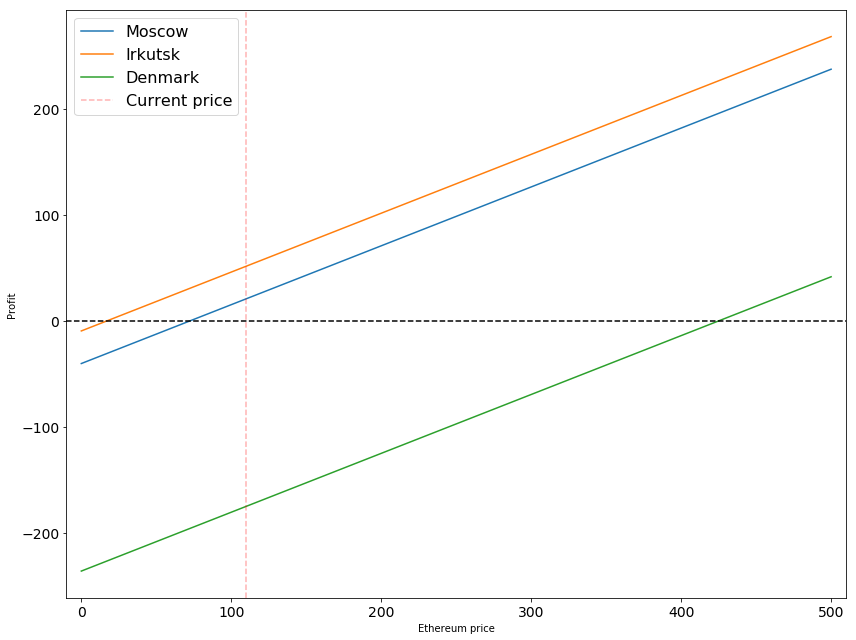

In [15]:
plt.figure(figsize=(12, 9))

for mining_location, mining_locations_result in mining_locations_results.items():
    plt.plot(etherium_price_list, mining_locations_result['profit_per_month'], label=mining_location)

plt.axhline(0, color='black', linestyle='--')
plt.axvline(110, color='red', linestyle='--', label='Current price', alpha=0.3)
plt.xlim(etherium_price_list.min() - 10, etherium_price_list.max() + 10)
plt.xlabel('Ethereum price')
plt.ylabel('Profit')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('pic/locations.png')

In [16]:
results = {}

for location in locations_list:
    location_name = location.name
    df = mining_locations_results[location_name]
    results_new = {
        location_name: float(df.loc[df['etherium_price']==110, 'profit_per_month'])        
    }
    results.update(results_new)

In [17]:
list(results.items())

[('Moscow', 20.77714285714286),
 ('Irkutsk', 51.53554285714286),
 ('Denmark', -175.06285714285715)]

In [18]:
keys, values = results.keys(), results.values()
keys, values = list(keys), list(values)

In [19]:
results_df = pd.DataFrame(values, index=keys, columns=['profit'])

### Barplot for location dependence.

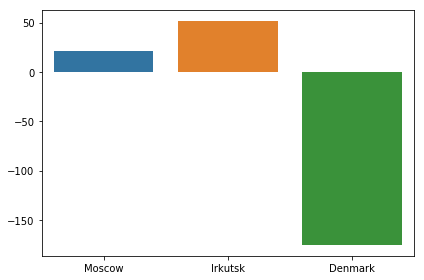

In [20]:
sns.barplot(data=results_df.T)
plt.tight_layout()
plt.savefig('pic/barchart.png')

# Ethereum price dynamic

In [21]:
df_etherium_prices = pd.read_csv('data/ETH-USD.csv', sep=';')

In [22]:
mask = df_etherium_prices['Date'] >= '2016-12-01'
df_etherium_prices = df_etherium_prices.loc[mask, :].reset_index(drop=True)
df_etherium_prices = df_etherium_prices[['Date', 'Adj Close']]
df_etherium_prices = df_etherium_prices.set_index('Date')

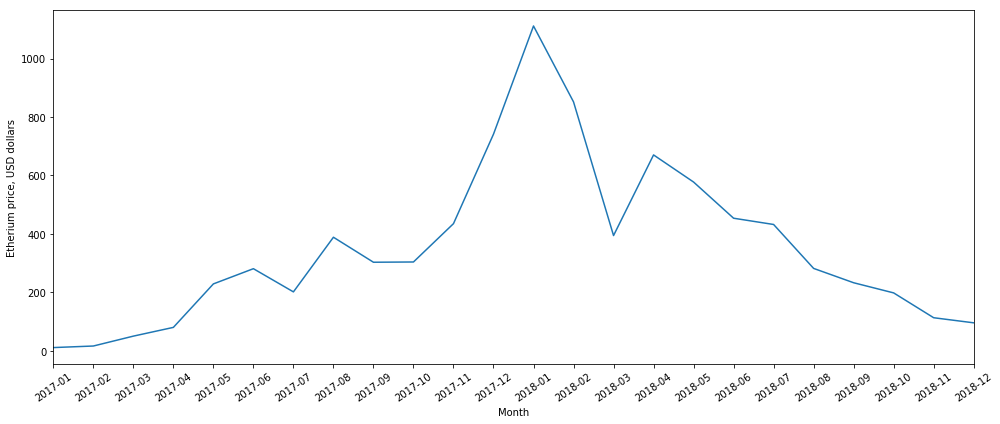

In [23]:
plt.close()

plt.figure(figsize=(14, 6))
dates = df_etherium_prices.index
prices = df_etherium_prices['Adj Close'].values

plt.xlim(0, len(dates) - 1)
plt.plot(prices)
plt.xticks(list(range(len(dates))), dates, rotation=35)
plt.ylabel('Etherium price, USD dollars')
plt.xlabel('Month')
plt.tight_layout()
plt.savefig('pic/etherium_price.png')